# Prediction of emergency room arrivals

## Initialization

### Initial import

In [1]:
%pylab inline

import datetime as dt
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xgboost

from math import sqrt

from category_encoders import TargetEncoder
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.10/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/usr/lib/python3.10/site-packages/statsmodels/compat/pandas.py:65: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import Int64Index as NumericIndex


### Loading data

### Cleaning data

In [9]:
df = df.loc[df.index.year<2020]
df = df.loc[~((df.index.day == 29) & (df.index.month == 2))]

In [10]:
df.month = df.index.month
df.dayofyear = df.index.dayofyear
df.dayofweek = df.index.dayofweek
df.hour = df.index.hour

In [11]:
df = df.replace(np.inf, np.nan)
df = df.bfill()

## Target visualization

In [13]:
series = pd.Series(data=df.patients.values, index=df.index)

In [14]:
series

date_hour_index
2010-01-01 00:00:00     5
2010-01-01 01:00:00    10
2010-01-01 02:00:00    14
2010-01-01 03:00:00    16
2010-01-01 04:00:00    15
                       ..
2019-12-31 19:00:00    18
2019-12-31 20:00:00    18
2019-12-31 21:00:00    11
2019-12-31 22:00:00     6
2019-12-31 23:00:00     8
Length: 87600, dtype: int64

In [15]:
series.describe()

count    87600.000000
mean        19.744201
std         11.446022
min          0.000000
25%         11.000000
50%         18.000000
75%         27.000000
max        146.000000
dtype: float64

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


/usr/lib/python3.10/site-packages/IPython/core/magics/pylab.py:162: UserWarning: pylab import has clobbered these variables: ['sqrt']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


<AxesSubplot:>

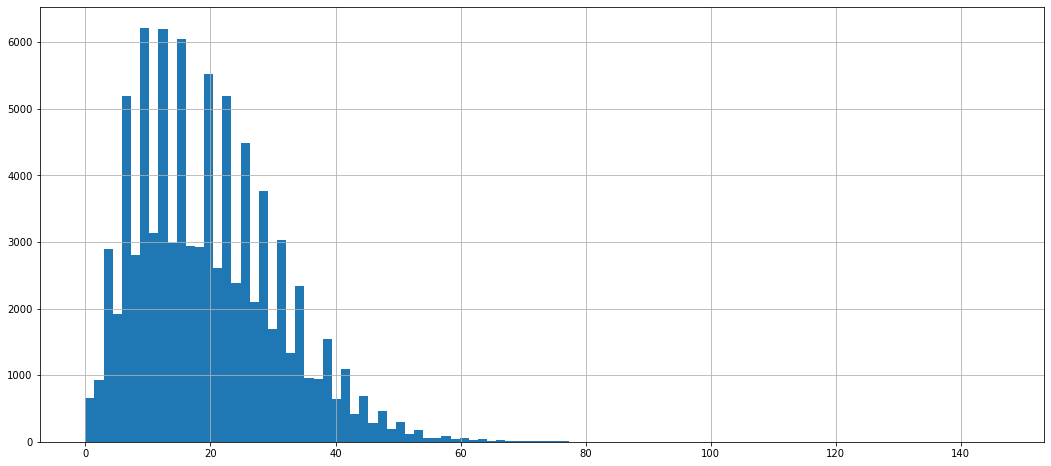

In [16]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 8)
series.hist(bins=100)

<AxesSubplot:xlabel='date_hour_index'>

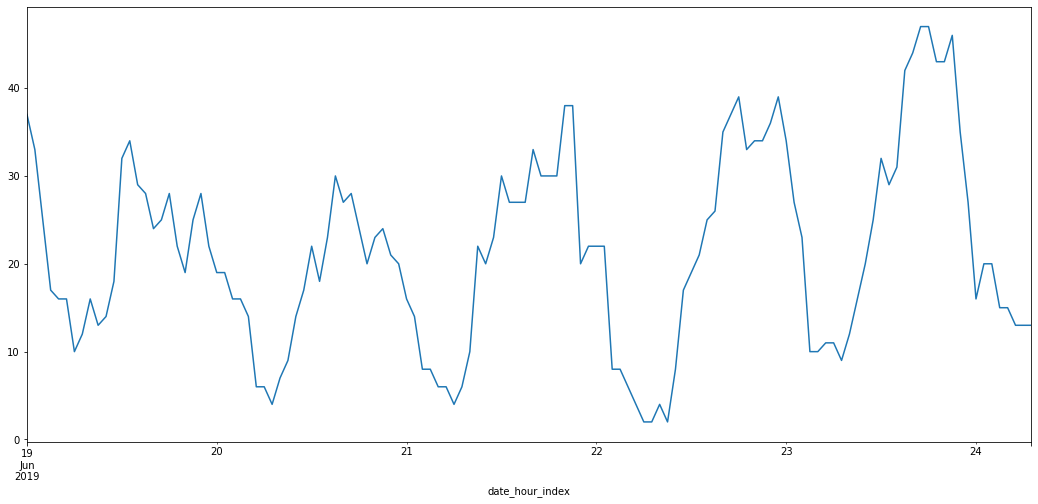

In [17]:
series['2019-06-19 00:00:00':'2019-06-24 07:00:00'].plot()

<AxesSubplot:xlabel='date_hour_index'>

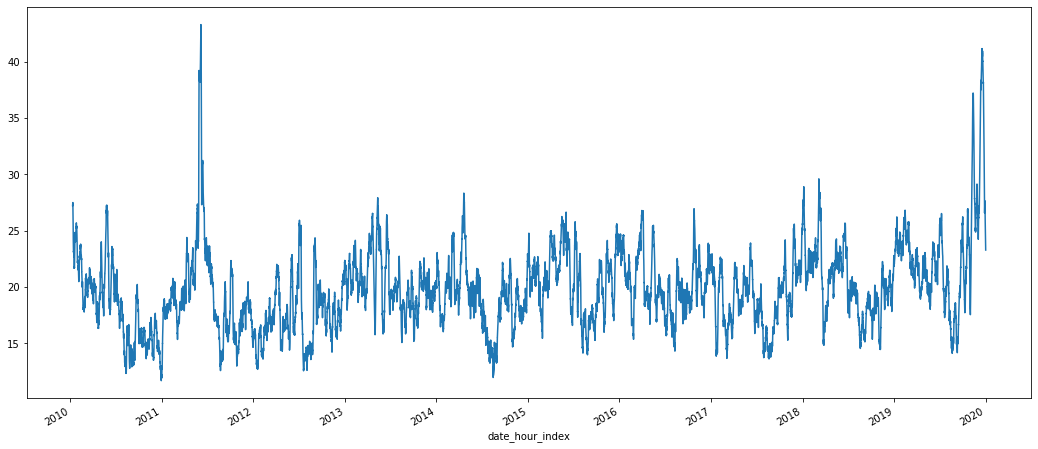

In [18]:
shifted = series.shift(1)
window = shifted.rolling(window=240)
means = window.mean()
means.plot()

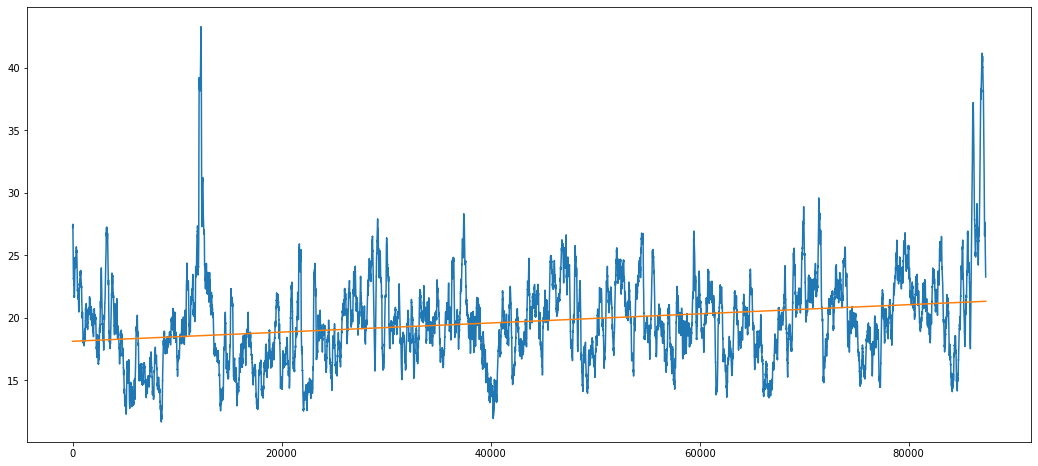

In [19]:
from sklearn.linear_model import LinearRegression

y = means.values[240:]
X = np.array(range(len(y))).reshape(-1, 1)
model = LinearRegression()
model.fit(X, y)
trend = model.predict(X)
pyplot.plot(X,means[240:])
pyplot.plot(X,trend)

In [20]:
print(f"{model.coef_[0]:.7F}, {(model.coef_*50000)[0]:.4f}")

0.0000366, 1.8301


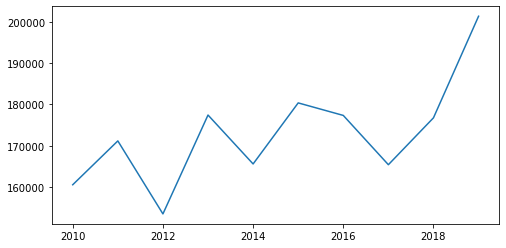

In [21]:
pylab.rcParams['figure.figsize'] = (8, 4)
plt.plot(range(2010,2020), [series[str(k)].sum() for k in range(2010,2020)])
pylab.rcParams['figure.figsize'] = (18, 8)

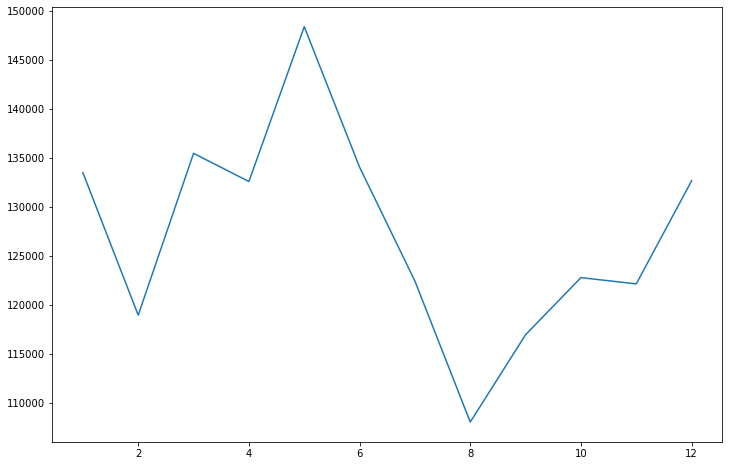

In [22]:
pylab.rcParams['figure.figsize'] = (12, 8)

g=df.groupby(['month','year'])
years = sorted(set(df.year.values))[:-1]
months = sorted(set(df.month.values))
plt.plot(range(1,13), [sum([g.get_group((int(l),int(k)))['patients'].sum() for k in years]) for l in months])

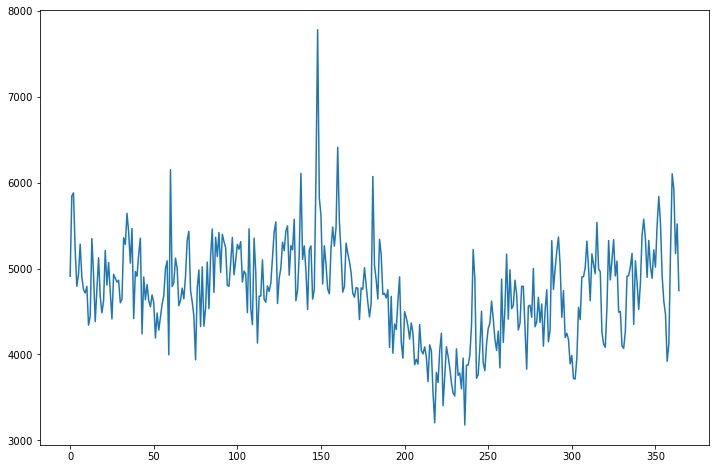

In [23]:
dd = df.loc[~((df.index.day == 29) & (df.index.month == 2))]
perday = [dd.loc[dd.dayofyear == k].patients.sum() for k in range(1,366)]
plt.plot(perday)

<AxesSubplot:>

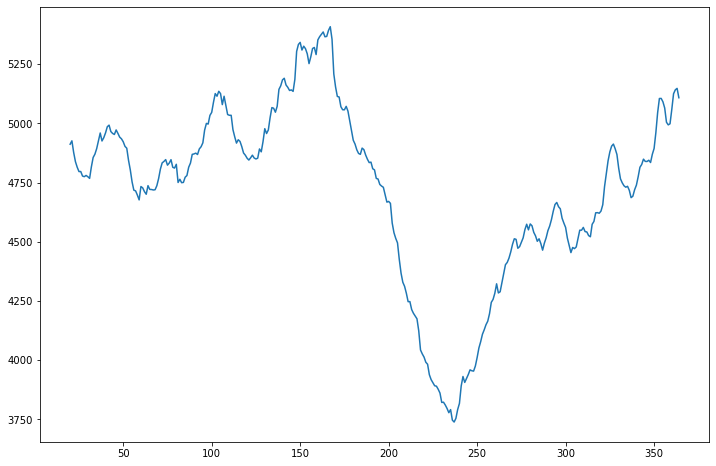

In [24]:
perday = pd.Series(perday)
window = perday.rolling(window=7*3)
means = window.mean()
means.plot()

(0.0, 125.0)

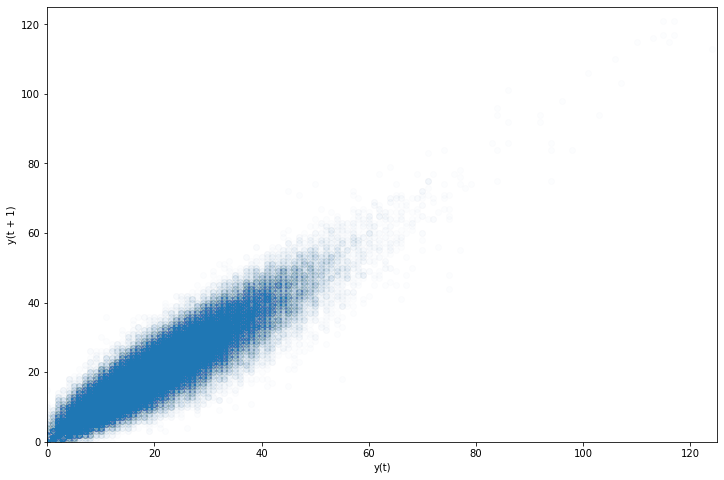

In [25]:
ax = pd.plotting.lag_plot(series, alpha=0.01)
ax.set_xlim([0, 125])
ax.set_ylim([0, 125])

(0.0, 168.0)

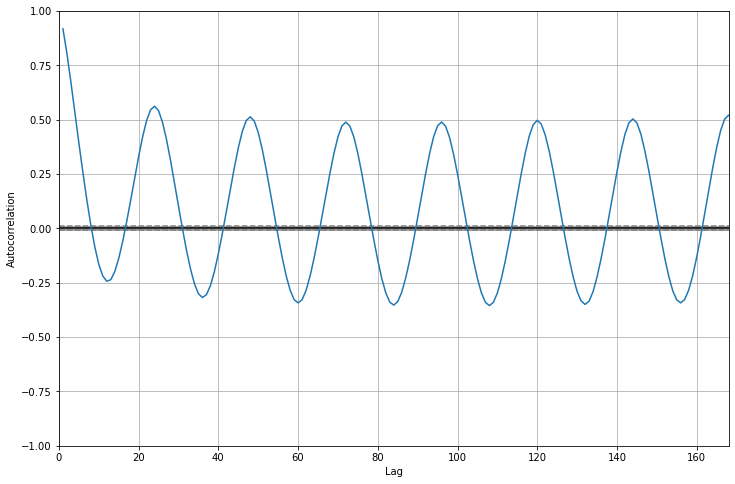

In [26]:
ax = pd.plotting.autocorrelation_plot(series)
ax.set_xlim([0, 24*7])

In [27]:
df0 = df.copy()
df0['hour'] = df0.index.hour
df0['dow'] = df0.index.dayofweek
df0['month'] = df0.index.month

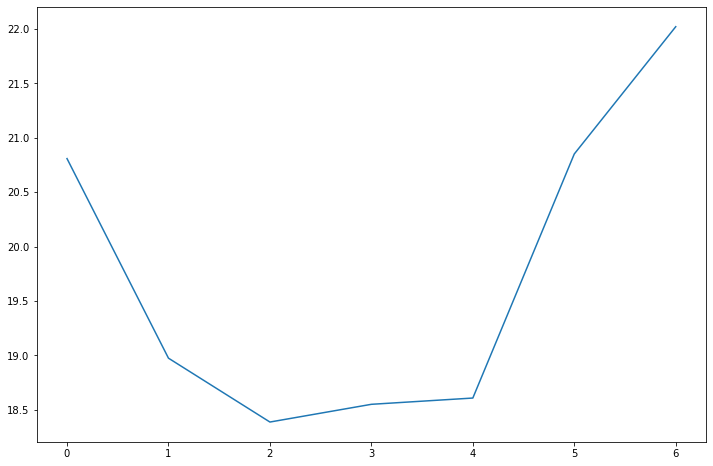

In [28]:
plt.plot(range(7), [df0.loc[df0.dow==k].patients.mean() for k in range(7)])

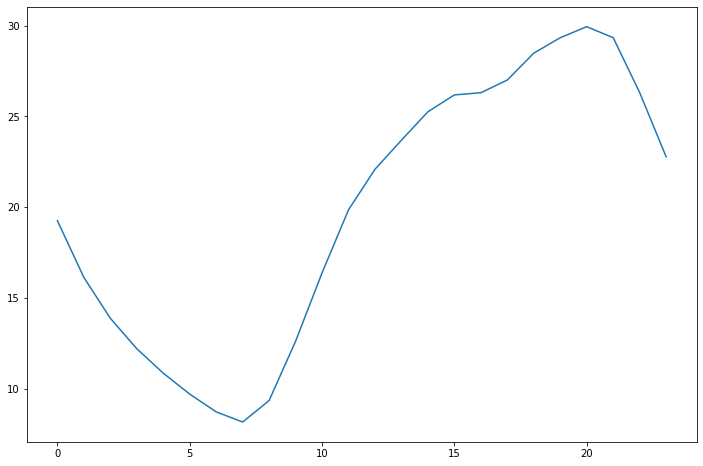

In [29]:
plt.plot(range(24), [df0.loc[df0.hour==k].patients.mean() for k in range(24)])

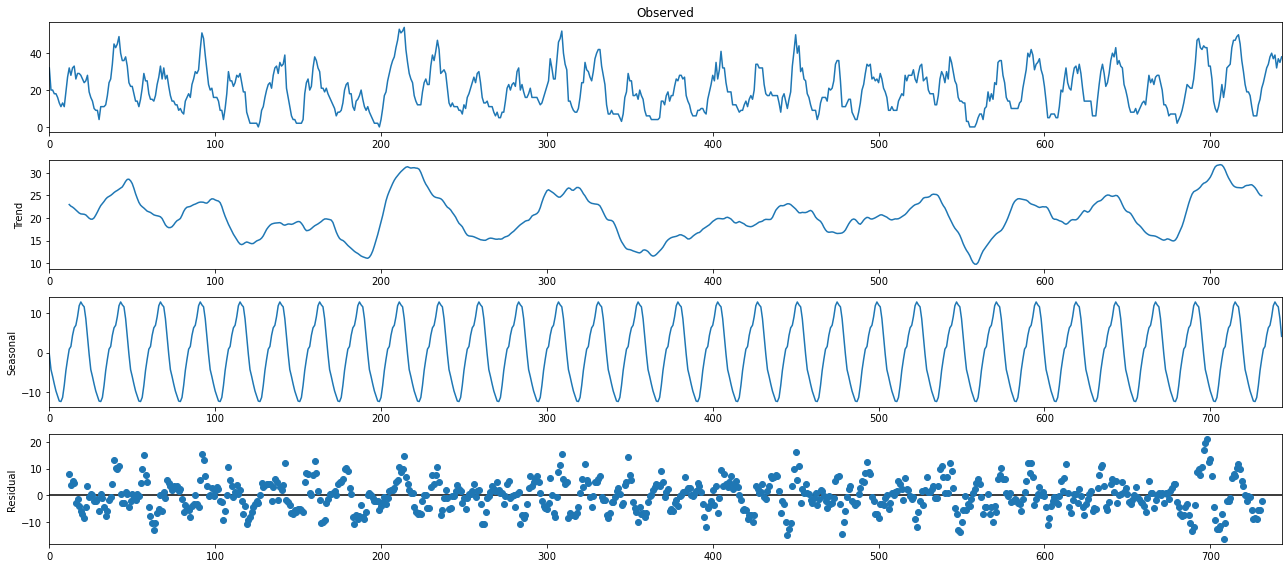

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose
pylab.rcParams['figure.figsize'] = (18, 8)

result = seasonal_decompose(list(series['2019-05']),
                            period=24)
result.plot()
pyplot.show()

## Mahuna : début

the number of cases may be just a cyclical
change, a baseline model should be provided to compare the superiority of
machine learnig model;

S'il s'agit uniquement de changements cycliques, le signal correspondrait à sa partie saisonnière dans une décomposition du même nom. On peut approximer le signal par sa composante saisonnière, pour voir à quel point un tel prédicteur appoxime bien le signal. On compare déjà le réel avec le prédit d'une telle manière : 

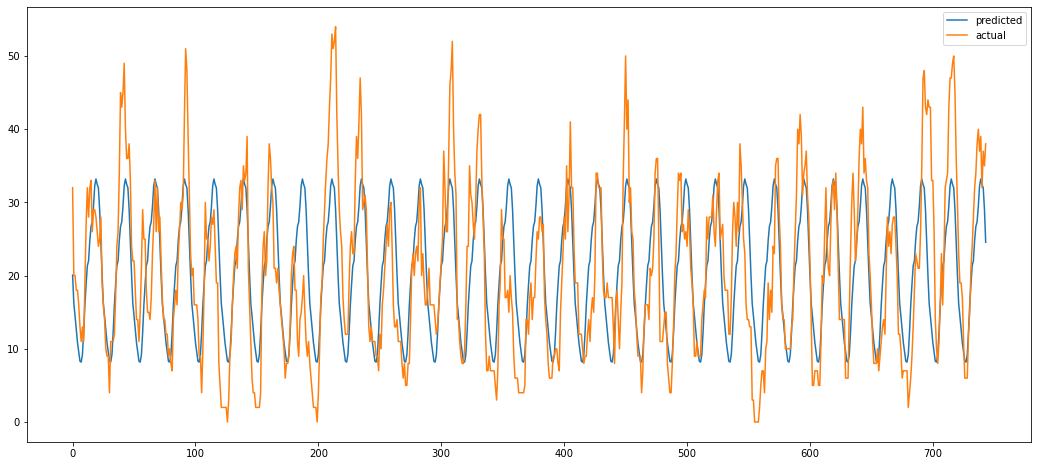

In [31]:
plot(result.seasonal + [result.observed.mean()]*len(result.seasonal), label="predicted")
plot(result.observed, label = "actual")
legend()

On affiche les résidus (erreurs de prédiction) : 

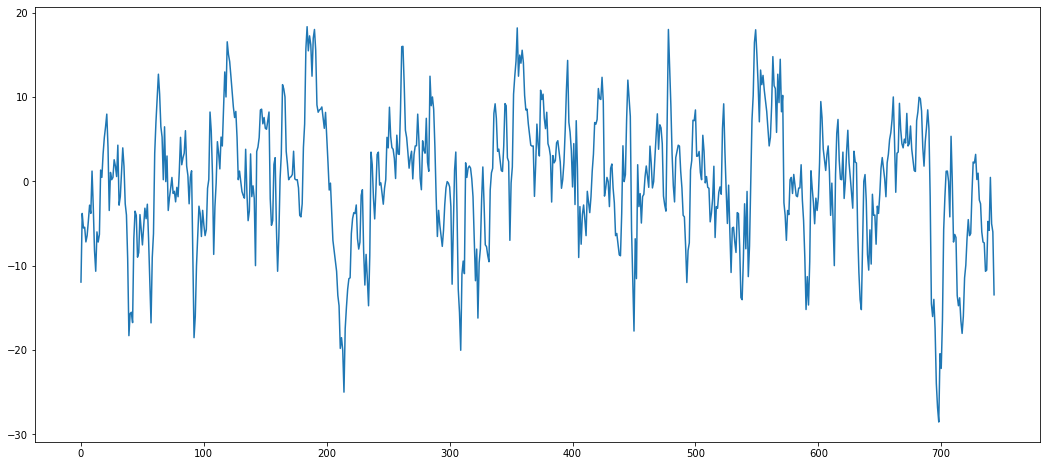

In [32]:
plot(result.seasonal + [result.observed.mean()]*len(result.seasonal)-result.observed, label="predicted")

Il n'y a plus de saisonnalité dans la courbe des résidus, ce qui est attendu, et l'on a une moyenne nulle. Les erreurs peuvent cependant être assez grandes (forte variance). Calculons la MAE et la RMSE de cette baseline :

In [33]:
mean_absolute_error(result.seasonal + [result.observed.mean()]*len(result.seasonal),result.observed)

5.8924896734609655

In [34]:
sqrt(mean_squared_error(result.seasonal + [result.observed.mean()]*len(result.seasonal), result.observed))

7.609380462886105

Ces valeurs seront à comparer avec les autres scores, pour justifier de l'intérêt d'une approche de type machine learning. A noter que Bel Air a un aspect légèrement plus cyclique que Mercy.

 Some time series analysis (ex. ARIMA) should be conducted.

On va tester les approches auto-régressive AR (méthode basique), ainsi que l'ARIMA.

In [35]:
dataframe = pd.concat([series.shift(1), series], axis=1)

In [36]:
dataframe.columns = [ ' t ' , ' t+1 ' ]

In [37]:
dataframe.corr()

,t,t+1
t,1.000000,0.917843
t+1,0.917843,1.000000


On constate une forte corrélation entre la série des patients, et sa version décalée d'une unité de temps : le signal est fortement auto-corrélé, et utiliser le nombre de patients aux temps t, t-1,... semble une bonne idée pour prédire celui au temps t+1. Cela est clairement apparent dans le graphe d'auto-corrélation :

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


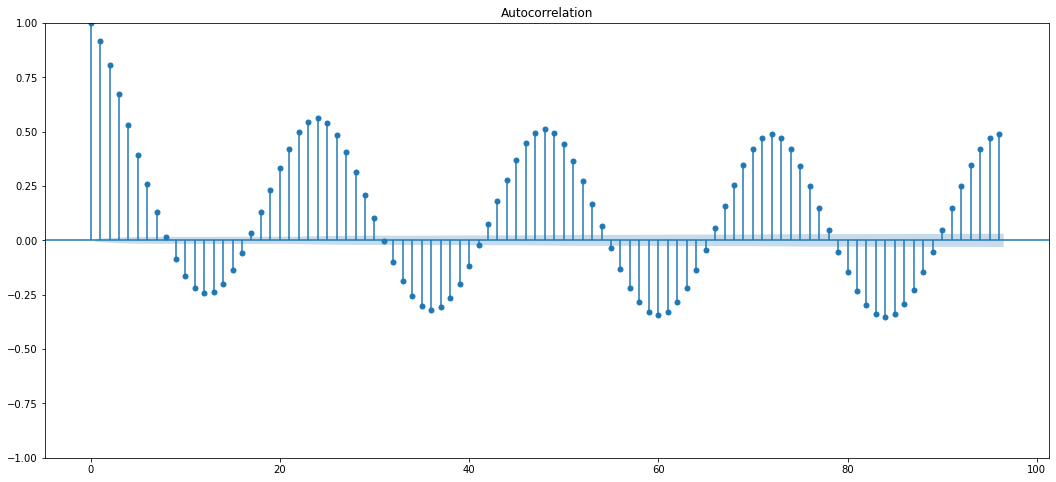

In [38]:
%pylab inline
pylab.rcParams['figure.figsize'] = (18, 8)

from statsmodels.graphics.tsaplots import plot_acf
plot_acf(series, lags=24*4)
show()

(on revoit apparaître la saisonnalité journalière).

Dans tous les cas, on peut conclure que le modèle AR est pertinent pour cette série. Le modèle AR dépend du nombre de retards à considérer dans la régression. On peut regarder s'il y a des valeurs à ignorer pour ce paramètre, par une approche "conditional maximum likelihood estimation".

In [40]:
from statsmodels.tsa.ar_model import ar_select_order
res = ar_select_order(series.values, maxlag=100)

In [41]:
res.ar_lags

[1,
 2,
 3,
 4,
 5,
 6,
 7,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 39,
 40,
 41,
 42,
 43,
 44,
 45,
 46,
 47,
 48,
 49,
 50,
 51,
 52,
 53,
 54,
 55,
 56,
 57,
 58,
 59,
 60,
 61,
 62,
 63,
 64,
 65,
 66,
 67,
 68,
 69,
 70,
 71,
 72,
 73,
 74,
 75,
 76,
 77,
 78,
 79,
 80,
 81,
 82,
 83,
 84,
 85,
 86,
 87,
 88,
 89,
 90,
 91,
 92,
 93,
 94,
 95,
 96,
 97,
 98,
 99]

Idem, aucune valeur n'est à banir. Au vu des tendances saisonnières, on prend en compte un retard allant jusqu'à 4 jours (aller plus loin complexifierait inutilement le modèle).

In [42]:
from statsmodels.tsa.ar_model import AutoReg

predictions = []
for k in range(100):
    train, test = series.values[:len(series)-100+k], series.values[len(series)-100+k]
    model = AutoReg(train, lags=24*4)
    model_fit = model.fit()
    predictions.append(model_fit.predict(start=len(train), 
                                    end=len(train), 
                                    dynamic=False))

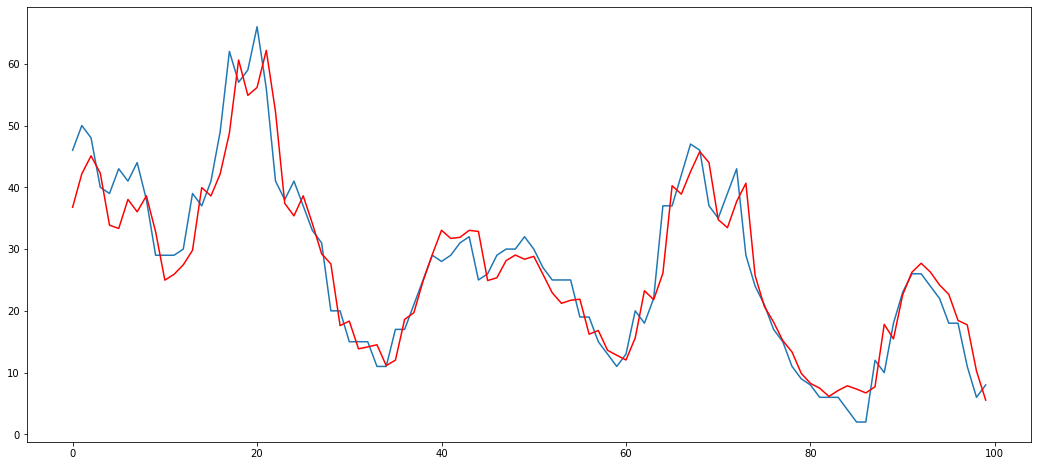

In [43]:
plot(range(100), series[-100:])
plot(range(100), predictions, color= 'red')

On calcule la RMSE et la MAE pour le modèle AR, sur les 100 dernières observations :

In [44]:
mean_absolute_error(series[-100:], predictions), sqrt(mean_squared_error(series[-100:], predictions))

(3.4560725169526334, 4.552427692616683)

Ces valeurs sont au-delà de celles que nous obtiendrons par des approches de machine learning.

Le modèle ARIMA, quant à lui, dépend de trois paramètres : 
- p (lag order) correspond au nombre d’observations passées intégrées dans le modèle.
- d (degree) correspond au nombre de soustractions opérées.
- q (order of moving average) correspond à la taille de la fenêtre la moyenne glissante (pour la série des résidus).
On peut passer par une grille pour trouver les paramètres optimaux, mais c'est très coûteux. On peut aussi suivre l'approche suivante, bien documentée dans la litérature :
- s’il y a une tendance générale à l’augmentation (ou a la diminution), i.e. une pente non nulle dans la régression linéaire, alors une étape de soustraction (d=1) peut être la bienvenue pour supprimer cette tendance. S’il y a une tendance à l’augmentation des fluctuations, on peut passer à d=2.
- Pour trouver la valeur de p, on trace le graphe d’autocorrélation, et on prend le plus grand retard encore significatif à 95%.
- Pour q, on fait de même, mais avec le graphe d’autocorrélation partielle.

On a vu précédemment qu'il y avait une tendance à la hausse, avec un bon coefficient de corrélation linéaire. On prend donc d=1.

Sur le graphe d'autocorrélation ci-dessus, on voit que le plus grand retard encore significatif à 95% est p=2 (à p=3, on est à ~85%).

Affichons maintenant le graphe d'autocorrélation partielle : 

/usr/lib/python3.10/site-packages/statsmodels/graphics/tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


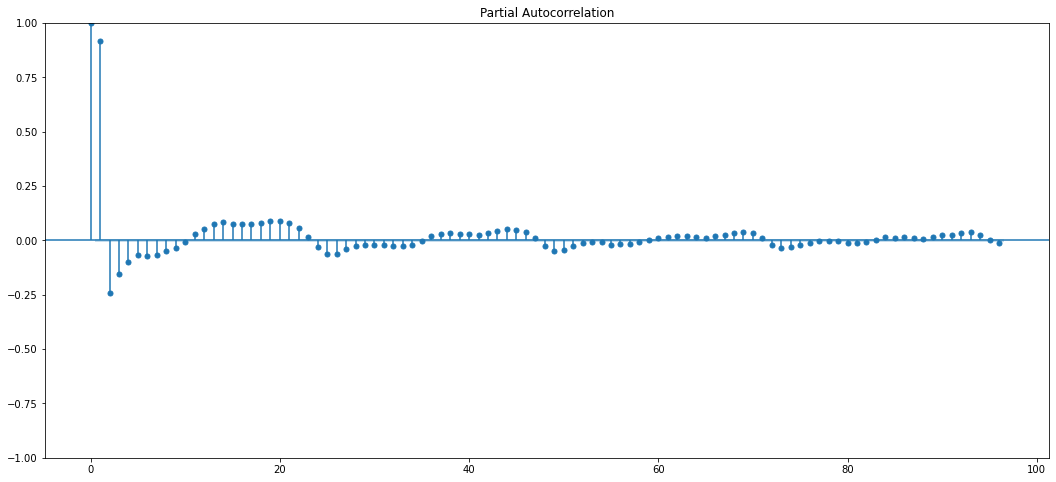

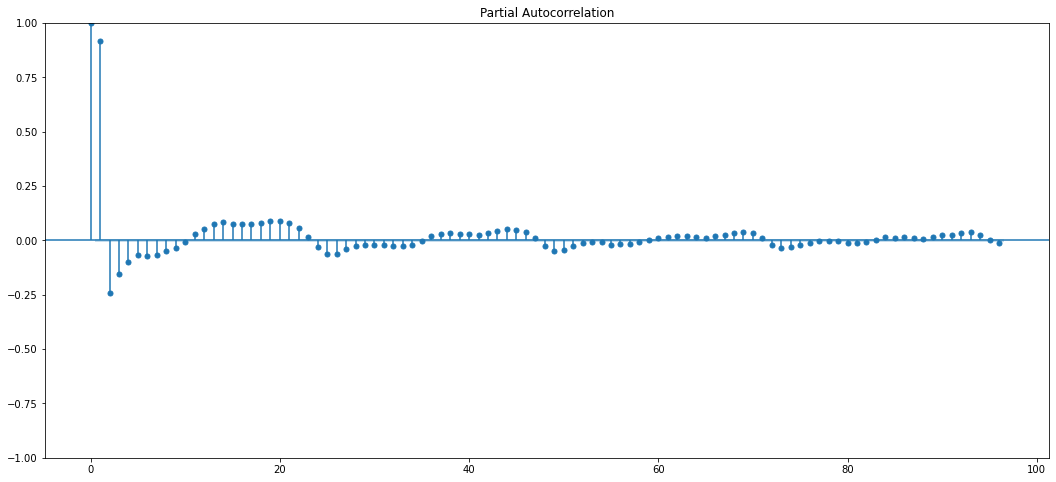

In [45]:
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(series, lags=24*4)

De même, on a une chute de l'autocorrélation partielle au-delà de q=2. On constate que les autocorrélations entre les deux hôpitaux sont proches, ce qui permet de répondre à la question de savoir si le modèle pourrait s'appliquer à d'autres hôpitaux : ils ont beau être différents, ils présentent fondamentalement une même dynamique, du fait qu'il s'agit toujours finalement de patients se rendant aux urgences. Les mêmes causes produisant les mêmes effets. On peut maintenant mettre en place le modèle :

In [46]:
from statsmodels.tsa.arima.model import ARIMA
X = series.values
size = 48
train, test = X[:-size], X[-size:]
history = [x for x in train]
predictions = list()

for t in range(len(test)):
    model = ARIMA(history, order=(2,1,2))
    model_fit = model.fit()
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)

/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "
/usr/lib/python3.10/site-packages/statsmodels/base/model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge.

Test RMSE: 4.133
Test MAE: 3.115


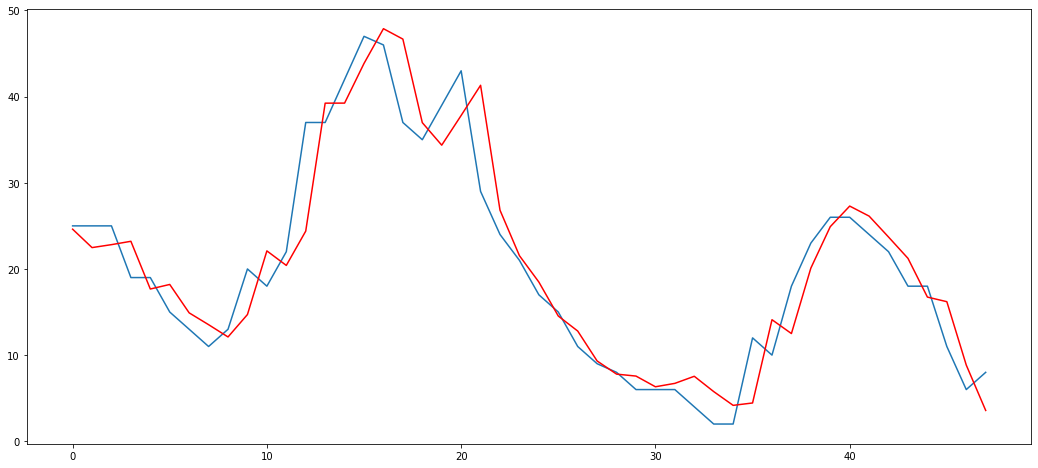

In [48]:
from matplotlib import pyplot

rmse = sqrt(mean_squared_error(list(test), list(predictions)))
print('Test RMSE: %.3f' % rmse)
mae = mean_absolute_error(list(test), list(predictions))
print('Test MAE: %.3f' % mae)
# plot forecasts against actual outcomes
pyplot.plot(test[:100])
pyplot.plot(predictions[:100], color='red')
pyplot.show()

Les scores sont toujours moins bons que l'approche ML.

In [31]:
import numpy as np
data = np.zeros((24,7))
for k in range(7):
    for l in range(24):
        data[l,k] = df0.loc[(df0['hour']==l)&(df0['dow']==k)]['patients'].mean()

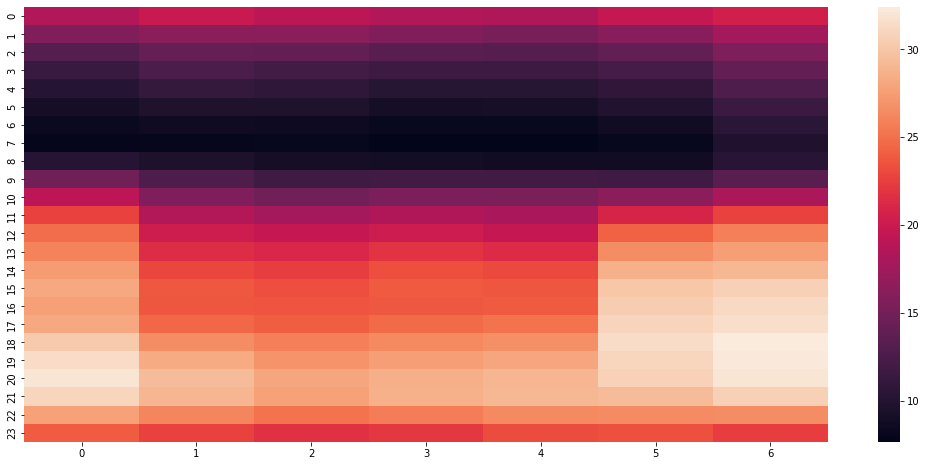

In [32]:
import seaborn as sns#; sns.set_theme()

ax = sns.heatmap(data)

Text(0.5, 1.0, 'Lundi')

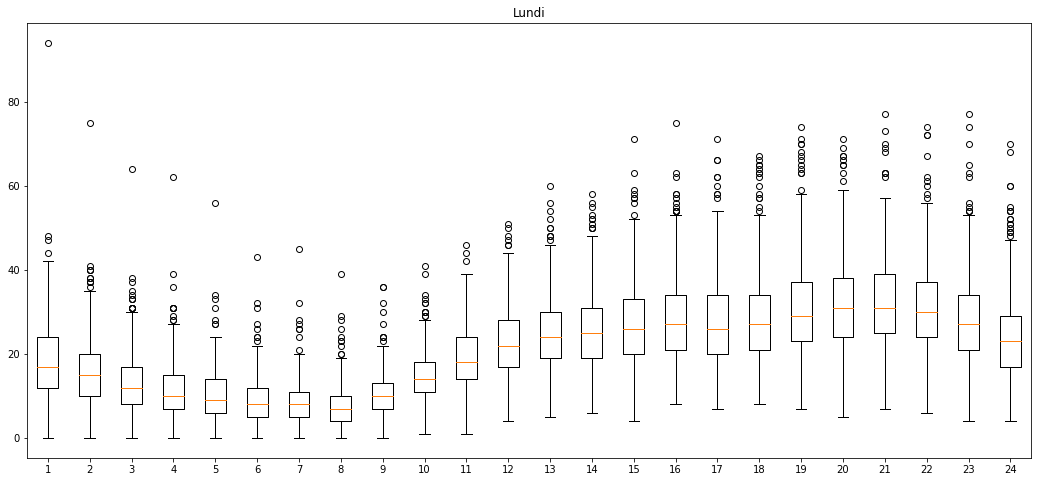

In [33]:
g=df0.groupby(['hour', 'dow'])
l=0
plt.boxplot([g.get_group((k,l))['patients'] for k in range(0,24)])
title("Lundi")

Text(0.5, 1.0, 'Lundi')

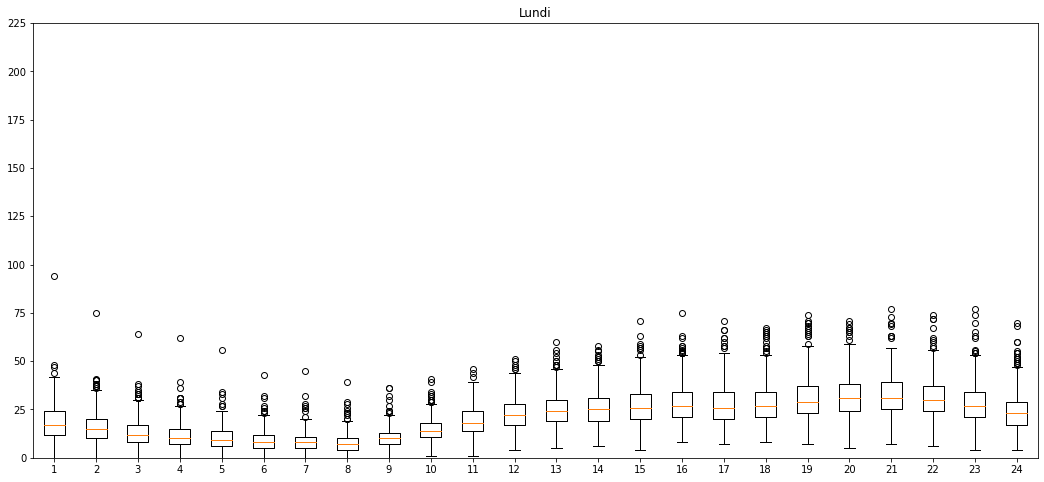

In [34]:
g=df0.groupby(['hour', 'dow'])
l=0
plt.boxplot([g.get_group((k,l))['patients'] for k in range(0,24)])
plt.ylim(0, 225)
title("Lundi")

## Predictions

### Baselines

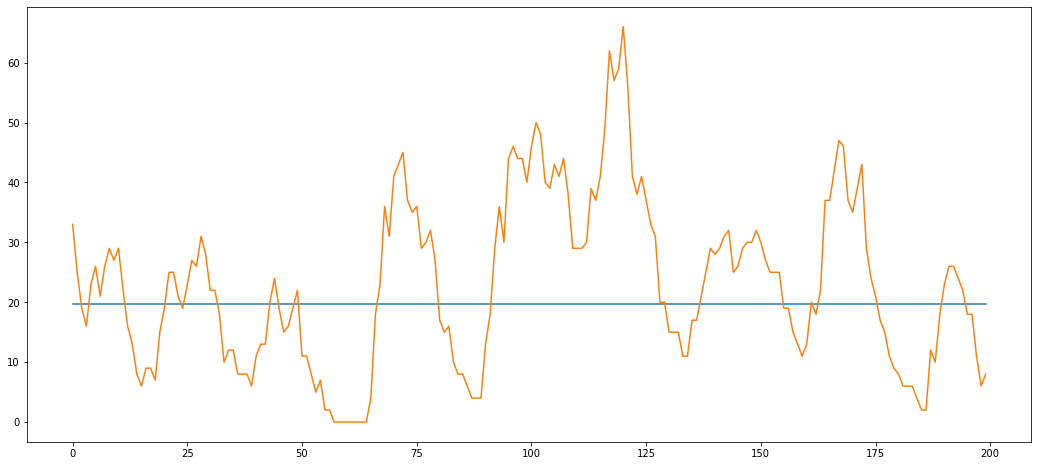

In [35]:
y_test = df['patients'].copy()
y_test_pred = [df['patients'].mean()]*len(y_test)
plot(range(200), y_test_pred[-200:], label="predicted")
plot(range(200), y_test[-200:], label="real")

In [36]:
mean_absolute_error(y_test_pred, y_test), sqrt(mean_squared_error(y_test_pred, y_test))

(9.127312001417817, 11.445957020888093)

In [37]:
for k in range(24):
    result = [df0.loc[df0.hour==k].patients.mean() for k in range(24)]*len(series)
    result = result[k:len(series)+k]
    print(k,mean_absolute_error(result, series.values), sqrt(mean_squared_error(result, series.values)))

0 6.480491893413398 8.72979034833396
1 6.703384812660286 8.98712796482325
2 7.334225439419528 9.672593245483613
3 8.201739719772315 10.614634198740818
4 9.176206474010133 11.661476751789476
5 10.170239901169701 12.709446455982622
6 11.12364452993057 13.70362631720419
7 12.015182804778885 14.61561909863313
8 12.818531725777193 15.421637817261354
9 13.492406724213424 16.09772183363035
10 14.00573590417214 16.61672489372627
11 14.330763401513732 16.945273299716995
12 14.443397103896913 17.05741650179311
13 14.340689303809347 16.945273299716995
14 14.028574673171955 16.616724893726275
15 13.526905767185838 16.09772183363035
16 12.867318258585101 15.421637817261354
17 12.083764808907237 14.61561909863313
18 11.205958209795458 13.703626317204192
19 10.255911540626759 12.709446455982622
20 9.26203451554388 11.661476751789477
21 8.281386420216428 10.614634198740818
22 7.401884037030088 9.672593245483613
23 6.7463689873021835 8.98712796482325


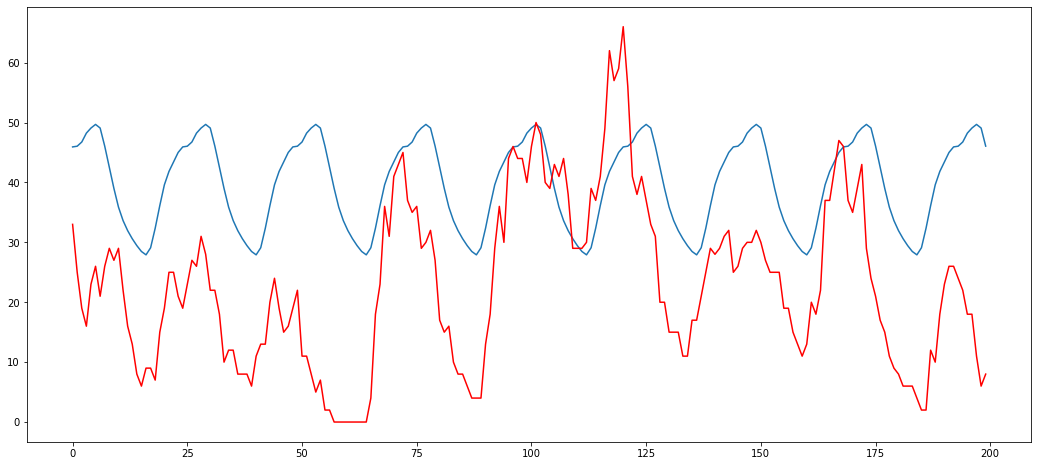

In [38]:
pyplot.plot(result[-200:]+series.mean())
pyplot.plot(series.values[-200:], color='red')

### More advanced approaches

#### Data preparation

In [39]:
target = 'patients'

In [40]:
lags = 24*7*4
for k in range(1, lags):
    df[f"{target}-{k}"] = df[target].shift(k)

/tmp/ipykernel_286772/3536442641.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  df[f"{target}-{k}"] = df[target].shift(k)


In [41]:
df = df[lags:]

In [42]:
cat = ['hour','week', 'dayofweek', 'month', 'year', 'dayofyear', 'daily_period', 'daily_period2',
       'apparent_moon','traffic_retour', 'accademic_holiday', 'moon_phase', 'public_holiday_eve',
       'traffic_depart',  'public_holiday', 'public_holiday_next_day']
num = ['influ_inc', 'ww_nancy','td_nancy', 'diar_inc100', 'moon_distance','vv_nancy', 't_nancy', 
       'chpox_inc100', 'cod_tend_nancy', 'u_nancy', 'diar_inc', 'chpox_inc','rr3_nancy', 'influ_inc100',
       'rafper_nancy', 'rr1_nancy', 'tend_nancy', 'pmer_nancy', 'pmer_strasbourg', 'dd_nancy',  
       'pres_nancy', 'n_nancy', 'ff_nancy']
num += ['encours']
num += [f"{target}-{k}" for k in range(1, lags)]
features = cat + num + [target]

In [43]:
df = df[features]

In [44]:
train_val_set, test_set = train_test_split(df, test_size=0.2, random_state=42)

split_date ='2020-01-01'
train_val_set = df.loc[df.index < split_date]
test_set = df.loc[df.index >= split_date]

In [45]:
enc = TargetEncoder(cols=cat)
encoder = enc.fit(train_val_set.drop(target, axis=1), train_val_set[target])

target_enc = encoder.transform(train_val_set.drop(target, axis=1))
target_enc[target] = train_val_set[target]
for col in cat:
    train_val_set[col] = target_enc[col]
    
target_enc = encoder.transform(test_set.drop(target, axis=1))
target_enc[target] = test_set[target]
for col in cat:
    test_set[col] = target_enc[col]

In [46]:
scaler = StandardScaler() 
scaler.fit(train_val_set.drop(target, axis=1))

target_enc = scaler.transform(train_val_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = train_val_set[target]
target_enc.index = train_val_set.index
for col in cat+num:
    train_val_set[col] = target_enc[col]

target_enc = scaler.transform(test_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = test_set[target]
target_enc.index = test_set.index
for col in cat+num:
    test_set[col] = target_enc[col]

In [47]:
X_train = train_val_set.drop('patients', axis=1)
y_train = train_val_set['patients'].copy()

X_test = test_set.drop('patients', axis=1)
y_test = test_set['patients'].copy()

#### Random forest

In [48]:
from sklearn.ensemble import RandomForestRegressor

reg = RandomForestRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

(1.9992327159783736, 2.680414315339155)

#### Lasso

In [49]:
from sklearn.linear_model import Lasso
reg = Lasso()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

(2.2390419295098294, 2.8931011413636347)

#### LightGBM

In [50]:
from lightgbm import LGBMRegressor

reg = LGBMRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

(1.9591403256259623, 2.619789919211298)

#### XGBoost

In [51]:
reg = xgboost.XGBRegressor()
reg.fit(X_train, y_train)

y_pred = reg.predict(X_test)
mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))

(2.0267821830304387, 2.7295741052706424)

In [52]:
reg1 = xgboost.XGBRegressor()
reg1.fit(X_train, y_train)
y_pred1 = reg1.predict(X_test)

reg2 = LGBMRegressor()
reg2.fit(X_train, y_train)
y_pred2 = reg2.predict(X_test)

reg3 = Lasso()
reg3.fit(X_train, y_train)
y_pred3 = reg3.predict(X_test)

reg4 = RandomForestRegressor()
reg4.fit(X_train, y_train)
y_pred4 = reg4.predict(X_test)

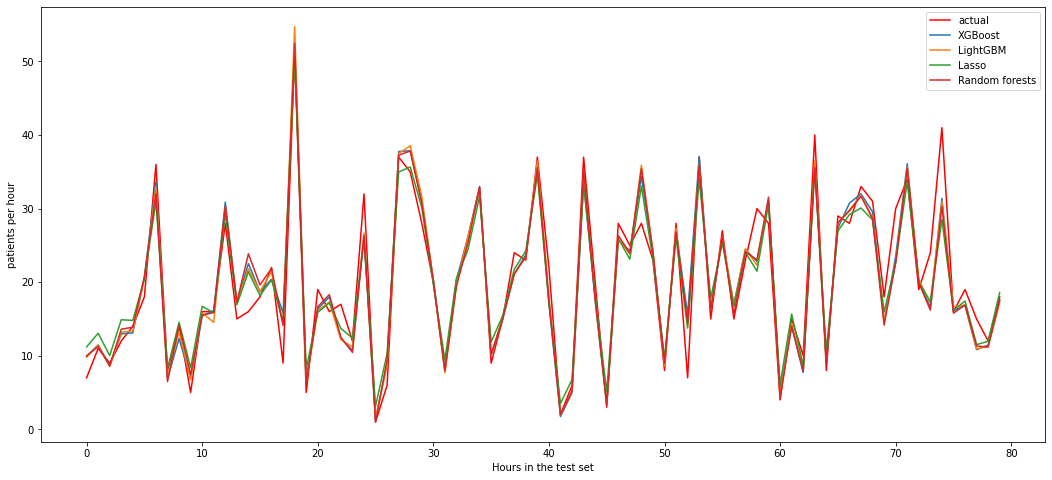

In [53]:
N=80
plt.plot(range(N),y_test[:N], color='red', label='actual')
plt.plot(range(N),y_pred1[:N], label="XGBoost")
plt.plot(range(N),y_pred2[:N], label="LightGBM")
plt.plot(range(N),y_pred3[:N], label="Lasso")
plt.plot(range(N),y_pred4[:N], label="Random forests")
xlabel("Hours in the test set")
ylabel("patients per hour")
legend()

#### Feature selection & hyperparameter optimization with XGBoost

In [54]:
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler
from sklearn.ensemble import ExtraTreesRegressor
import pandas as pd
from sklearn.feature_selection import RFE

def get_features(df, target = 'appels', num_feats = 100):
    print("Coefficient de corrélation")
    ix = df.corr().sort_values(target, ascending=False).index
    df_sorted = df.loc[:, ix]
    Liste = list(df_sorted.columns)
    X = df.drop(target, axis=1)
    y = df[target]
    '''print("Random forests")
    embeded_rf_selector = SelectFromModel(
                    RandomForestRegressor(n_estimators=100),
                    max_features=num_feats)
    embeded_rf_selector.fit(X, y)
    embeded_rf_support = embeded_rf_selector.get_support()
    embeded_rf_feature = X.loc[:,embeded_rf_support].columns.tolist()'''
    print("Régression linéaire")
    embeded_lr_selector = SelectFromModel(LinearRegression(),
                                      max_features=num_feats)
    embeded_lr_selector.fit(X, y)
    embeded_lr_support = embeded_lr_selector.get_support()
    embeded_lr_feature = X.loc[:,embeded_lr_support].columns.tolist()
    '''print("Chi-2 selector")
    X_norm = MinMaxScaler().fit_transform(X)
    chi_selector = SelectKBest(chi2, k=num_feats)
    chi_selector.fit(X_norm, y)
    chi_support = chi_selector.get_support()
    chi_feature = X.loc[:,chi_support].columns.tolist()'''
    print("Extra trees")
    model = ExtraTreesRegressor()
    model.fit(X,y)
    feat_importances = pd.Series(model.feature_importances_, index=X.columns)
    xt_features = list(feat_importances.nlargest(100).index)
    print("XGBoost")
    train_set, val_set = train_test_split(df, test_size=0.2)
    X_train = train_set.drop(target, axis=1)
    X_val = val_set.drop(target, axis=1)
    y_train = train_set[target]
    y_val = val_set[target]
    reg = xgboost.XGBRegressor(random_state = 42,
                               max_depth = 7,
                               n_estimators=100000)
    reg.fit(X_train, y_train,
            eval_set = [(X_val, y_val)],
            early_stopping_rounds = 10, verbose=False)
    a, b = X_train.columns, reg.feature_importances_
    res_xgb = sorted([(a[k], b[k]) for k in range(len(X.columns))], key=lambda x:x[1], reverse=True)
    features_xgb = [k[0] for k in res_xgb[:100]]
    print("LightGBM")
    lgbc=LGBMRegressor(n_estimators=500)
    embeded_lgb_selector = SelectFromModel(lgbc, max_features=num_feats)
    embeded_lgb_selector.fit(X, y)
    embeded_lgb_support = embeded_lgb_selector.get_support()
    embeded_lgb_feature = X.loc[:,embeded_lgb_support].columns.tolist()
    print("RFE Lasso")
    rfe_selector = RFE(estimator=Lasso(alpha=0.1),
                   n_features_to_select=num_feats,
                   step=100, verbose=5)
    rfe_selector.fit(X, y)
    rfe_support = rfe_selector.get_support()
    rfe_feature = X.loc[:,rfe_support].columns.tolist()
    total = Liste[:int(num_feats/2)]+Liste[-int(num_feats/2):]+embeded_lr_feature+xt_features+features_xgb+embeded_lgb_feature+rfe_feature
    return sorted(set([(k, total.count(k)) for k in total if total.count(k)>1]), key=lambda x:x[1], reverse=True)

In [55]:
variables = get_features(train_val_set, target=target, num_feats = 50)

Coefficient de corrélation
Régression linéaire
Extra trees
XGBoost
LightGBM
RFE Lasso
Fitting estimator with 711 features.
Fitting estimator with 611 features.
Fitting estimator with 511 features.
Fitting estimator with 411 features.
Fitting estimator with 311 features.
Fitting estimator with 211 features.
Fitting estimator with 111 features.


In [56]:
variables

[('patients-1', 6),
 ('encours', 6),
 ('hour', 6),
 ('patients-118', 5),
 ('daily_period', 4),
 ('dayofweek', 4),
 ('patients-4', 4),
 ('patients-142', 4),
 ('patients-22', 4),
 ('patients-120', 4),
 ('u_nancy', 4),
 ('patients-2', 4),
 ('patients-334', 3),
 ('t_nancy', 3),
 ('patients-502', 3),
 ('patients-166', 3),
 ('patients-3', 3),
 ('patients-8', 3),
 ('patients-23', 3),
 ('patients-478', 3),
 ('patients-613', 3),
 ('patients-46', 3),
 ('patients-238', 3),
 ('patients-189', 3),
 ('patients-7', 3),
 ('patients-121', 3),
 ('patients-333', 3),
 ('patients-357', 3),
 ('patients-335', 2),
 ('patients-516', 2),
 ('patients-144', 2),
 ('patients-260', 2),
 ('patients-336', 2),
 ('patients-192', 2),
 ('patients-225', 2),
 ('patients-168', 2),
 ('diar_inc100', 2),
 ('patients-245', 2),
 ('patients-636', 2),
 ('diar_inc', 2),
 ('patients-585', 2),
 ('patients-396', 2),
 ('patients-501', 2),
 ('patients-292', 2),
 ('patients-580', 2),
 ('patients-647', 2),
 ('patients-444', 2),
 ('patients-

In [57]:
train_val_set0 = train_val_set.copy()

In [58]:
from sklearn.model_selection import KFold

def teste(df, variables, max_depth = 1, ok = target):
    liste = [k for k in df.columns if k not in variables]
    if ok not in liste:
        liste.append(ok)
    if max_depth == 1:
        etendue = range(2,16)
    else:
        etendue = [max_depth]
    txt = str(variables)
    txt += '\n'
    min_rmse, best_depth = None, None
    for max_depth in etendue:
        kf = KFold(n_splits=5, random_state=42, shuffle=True)
        RMSEs = []
        for train_index, test_index in kf.split(df):
            train_val_set, test_set = df.iloc[train_index], df.iloc[test_index]
            train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)
            X_train = train_set.drop(liste, axis=1)
            X_val = val_set.drop(liste, axis=1)
            X_test = test_set.drop(liste, axis=1)
            y_train = train_set[ok]
            y_val = val_set[ok]
            y_test = test_set[ok]
            reg = xgboost.XGBRegressor(random_state = 42,
                                       learning_rate=0.1,
                                       max_depth = max_depth,
                                       n_estimators=10000,
                                       #objective = 'count:poisson',
                                       #eval_metric = 'poisson-nloglik',
                                       verbosity=0)
            reg.fit(X_train, y_train,
                    eval_set = [(X_val, y_val)],
                    early_stopping_rounds = 15,
                    verbose=False)
            y_pred = reg.predict(X_test)
            RMSEs.append(sqrt(mean_squared_error(y_test, y_pred)))
        rmse = mean(RMSEs)
        txt += str(max_depth)+' '+str(mean_absolute_error(y_test, y_pred))+' '+str(rmse)
        txt += '\n'
        if not min_rmse:
            min_rmse = rmse
            reg0 = deepcopy(reg)
            best_depth = max_depth
        elif rmse < min_rmse:
            min_rmse = rmse
            best_depth = max_depth
            reg0 = deepcopy(reg)            
    print(txt)
    return (reg0, min_rmse, best_depth)


In [59]:


train_val_set, test_set = df.loc[df.year<2019], df.loc[df.year==2019]

enc = TargetEncoder(cols=cat)
encoder = enc.fit(train_val_set.drop(target, axis=1), train_val_set[target])

target_enc = encoder.transform(train_val_set.drop(target, axis=1))
target_enc[target] = train_val_set[target]
for col in cat:
    train_val_set[col] = target_enc[col]
    
target_enc = encoder.transform(test_set.drop(target, axis=1))
target_enc[target] = test_set[target]
for col in cat:
    test_set[col] = target_enc[col]
    

scaler = StandardScaler() 
scaler.fit(train_val_set.drop(target, axis=1))

target_enc = scaler.transform(train_val_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = train_val_set[target]
target_enc.index = train_val_set.index
for col in cat+num:
    train_val_set[col] = target_enc[col]

target_enc = scaler.transform(test_set.drop(target, axis=1))
target_enc = pd.DataFrame(target_enc, columns = cat+num)
target_enc[target] = test_set[target]
target_enc.index = test_set.index
for col in cat+num:
    test_set[col] = target_enc[col]

    
var = ['encours', 'patients-1', 'hour', 'year', 'patients-3', 'daily_period2', 'patients-2']
train_val_set = train_val_set[var+['patients']]
test_set = test_set[var+['patients']]

train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

'''X_train = train_val_set.drop('patients', axis=1)
y_train = train_val_set['patients'].copy()

X_test = test_set.drop('patients', axis=1)
y_test = test_set['patients'].copy()
'''


X_train = train_set.drop(target, axis=1)
X_val = val_set.drop(target, axis=1)
y_train = train_set[target]
y_val = val_set[target]


X_test = test_set.drop([target], axis=1)
y_test = test_set[target]


ok = []
depth = 5

reg = xgboost.XGBRegressor(random_state = 42,
                           max_depth = depth,
                           n_estimators = 10000,
                           objective = 'count:poisson')

reg.fit(X_train, y_train,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 10)
y_pred = reg.predict(X_test[var])
ok.append((depth, mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))))
print(ok)

/tmp/ipykernel_286772/2341641699.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train_val_set[col] = target_enc[col]
/tmp/ipykernel_286772/2341641699.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_set[col] = target_enc[col]
/tmp/ipykernel_286772/2341641699.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/

[0]	validation_0-poisson-nloglik:53.77040
[1]	validation_0-poisson-nloglik:49.83455
[2]	validation_0-poisson-nloglik:45.93201
[3]	validation_0-poisson-nloglik:42.07092
[4]	validation_0-poisson-nloglik:38.26112
[5]	validation_0-poisson-nloglik:34.51434
[6]	validation_0-poisson-nloglik:30.84553
[7]	validation_0-poisson-nloglik:27.27342
[8]	validation_0-poisson-nloglik:23.82000
[9]	validation_0-poisson-nloglik:20.51242
[10]	validation_0-poisson-nloglik:17.38742
[11]	validation_0-poisson-nloglik:14.48356
[12]	validation_0-poisson-nloglik:11.84311
[13]	validation_0-poisson-nloglik:9.51889
[14]	validation_0-poisson-nloglik:7.55536
[15]	validation_0-poisson-nloglik:5.99567
[16]	validation_0-poisson-nloglik:4.85006
[17]	validation_0-poisson-nloglik:4.06774
[18]	validation_0-poisson-nloglik:3.55286
[19]	validation_0-poisson-nloglik:3.21477
[20]	validation_0-poisson-nloglik:2.99009
[21]	validation_0-poisson-nloglik:2.83720
[22]	validation_0-poisson-nloglik:2.73109
[23]	validation_0-poisson-nlogl

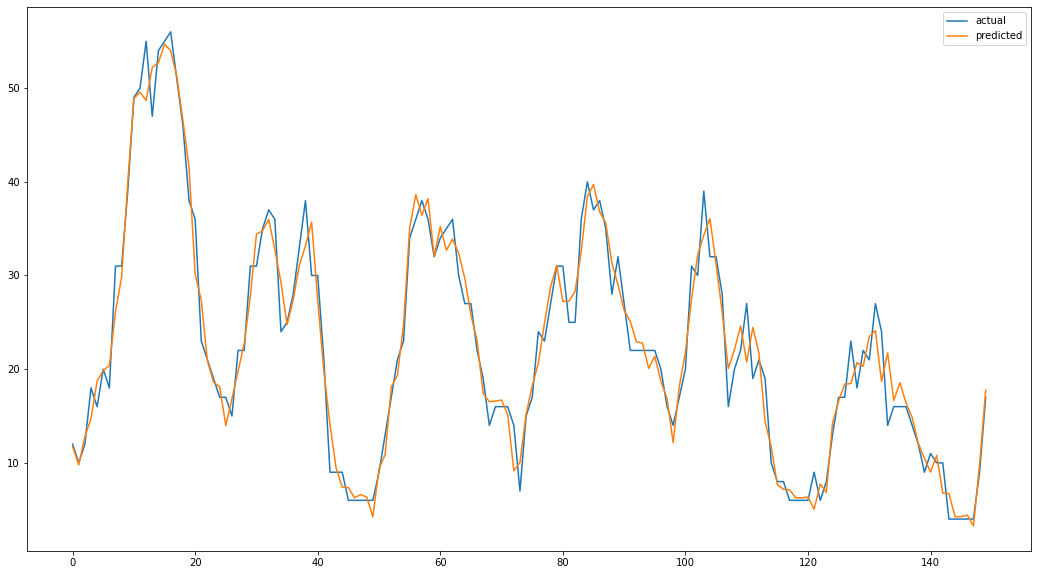

In [60]:
pylab.rcParams['figure.figsize'] = (18, 10)
N=150
plt.plot(range(N), y_test[N:2*N], label='actual')
plt.plot(range(N), y_pred[N:2*N], label='predicted')
plt.legend()

In [61]:
assert False

AssertionError: 

In [ ]:
from copy import deepcopy
from pickle import dump

mes_vars = [variables[0][0]]
reg0, best_rmse, best_depth = teste(train_val_set0, mes_vars)

variables = [k[0] for k in variables if k[0] not in mes_vars]
variables = [k for k in variables if k not in ['trend', 'creneau']]
    
print(variables)
les_rmse = [best_rmse]
for k in range(20):
    for var in variables:
        var0 = var
        print(k, ', '.join(mes_vars+[var]))
        reg, min_rmse, max_depth = teste(train_val_set0, mes_vars+[var])
        print(min_rmse, best_rmse)
        if min_rmse < best_rmse:
            print(k, "amélioration", best_rmse, "->", min_rmse)
            reg0, best_rmse, best_depth = reg, min_rmse, max_depth
            with open(f'regs/{target}-{best_rmse:.5f}_{best_depth}_{k}.pkl', 'wb') as f:
                 dump(reg0, f)
            mes_vars.append(var)
            les_rmse.append(best_rmse)
            variables.remove(var)
            with open(f'regs/{target}-{best_rmse:.5f}_{best_depth}_{k}.txt', 'w') as f:
                 f.write(str(mes_vars))
            break
    if var0 == variables[-1]:
        break

In [ ]:
depth = 5
var = ['hour', 'patients-1', 'encours', 'year', 'patients-3', 'patients-2', 'daily_period2']
train_val_set = train_val_set0[var+['patients']]

train_set, val_set = train_test_split(train_val_set, test_size=0.2, random_state=42)

X_train = train_set.drop(target, axis=1)
X_val = val_set.drop(target, axis=1)
y_train = train_set[target]
y_val = val_set[target]


X_test = test_set.drop([target], axis=1)
y_test = test_set[target]

ok = []
reg = xgboost.XGBRegressor(random_state = 42,
                           max_depth = depth,
                           n_estimators = 10000,
                           objective = 'count:poisson')

reg.fit(X_train, y_train,
        eval_set = [(X_val, y_val)],
        early_stopping_rounds = 10)
y_pred = reg.predict(X_test[var])
ok.append((depth, mean_absolute_error(y_test, y_pred), sqrt(mean_squared_error(y_test, y_pred))))
print(ok)

In [ ]:
pylab.rcParams['figure.figsize'] = (18, 10)
N=150
plt.plot(range(N), y_test[:N], label='actual')
plt.plot(range(N), y_pred[:N], label='predicted')
plt.legend()

In [ ]:
pylab.rcParams['figure.figsize'] = (18, 10)
N=150
plt.plot(range(N), y_test[-N:], label='actual')
plt.plot(range(N), y_pred[-N:], label='predicted')
plt.legend()

| Method | MAE | RMSE |
| --- | --- | --- |
| Mean | 12.13 | 15.20 |
| Mean / hour | 8.70 | 11.65 |
| Lasso | 2.90 | 3.80 |
| XGBoost | 2.76 | 3.74 |
| Random forests | 2.73 | 3.67 |
| LightGBM | 2.66 | 3.59 |
| Now | 2.64 | 3.59 |

In [ ]:
dd = open('BelAI.txt').read()

In [ ]:
gg=[k for k in dd.split('\n') if k.startswith('5 ')]

In [ ]:
mae = [eval(k.split(' ')[1]) for k in gg if 'patients' not in k and 'amélioration' not in k]
rmse = [eval(k.split(' ')[2]) for k in gg if 'patients' not in k and 'amélioration' not in k]

In [ ]:
%pylab inline
pylab.rcParams['font.size'] = "16"
pylab.rcParams['figure.figsize'] = (18, 8)

plt.plot(mae[2:], label='MAE')

rolling = pd.Series(mae).rolling(window=30)
rolling_mean = rolling.mean()
plt.plot(rolling_mean[31:], label="Rolling mean")
legend()
xlabel('Number of iterations')
ylabel('Mean absolute error')

In [ ]:
plt.plot(rmse[2:], label='RMSE')

rolling = pd.Series(rmse).rolling(window=30)
rolling_mean = rolling.mean()
plt.plot(rolling_mean[31:], label='Rolling mean')

legend()
xlabel('Number of iterations')
ylabel('Root mean squared error')

In [ ]:
un = """2 4.794014936159286 6.371670393224022
3 4.793586852497707 6.370913445116344
4 4.792359068111198 6.3713927200872575
5 4.792378685084917 6.372013920224714
6 4.792392527796531 6.373517850960837
7 4.793804649789682 6.3742724400133435
8 4.793890363943107 6.3748746868489015
9 4.7943779703937865 6.375547999331991
10 4.794325483867002 6.37593450773726
11 4.794779548725247 6.376251418626509
12 4.793965917004571 6.376329528566106
13 4.794928880800007 6.376536425157527
14 4.7948453495445555 6.37648611513372
15 4.7949558118824855 6.376549844120044"""

un_mae = [eval(k.split(' ')[1]) for k in un.split('\n')]
un_rmse = [eval(k.split(' ')[2]) for k in un.split('\n')]

In [ ]:
deux = """2 4.249689975817176 5.688744329191133
3 4.243140976517099 5.683624047901641
4 4.242725341093585 5.682827103155548
5 4.239193104008233 5.68537435912304
6 4.244717813897551 5.692056955102548
7 4.250510965248686 5.699532204023779
8 4.255128972988757 5.707718337150459
9 4.2635696686982145 5.71742241299491
10 4.271951119465014 5.731523241127482
11 4.279692809759868 5.7447603458166725
12 4.287327868750906 5.755606246714571
13 4.292338499292862 5.764188710376482
14 4.297324060484647 5.768430340650471
15 4.297979949207198 5.772737162704191"""

deux_mae = [eval(k.split(' ')[1]) for k in deux.split('\n')]
deux_rmse = [eval(k.split(' ')[2]) for k in deux.split('\n')]

In [ ]:
trois = """2 2.660870466710234 3.610368170986586
3 2.662460413570458 3.606900413067347
4 2.659576451209279 3.609797668872239
5 2.6594095583410486 3.6097468529486063
6 2.659174259757392 3.6144756027752534
7 2.6607027971452255 3.623001095229852
8 2.6641251048352275 3.6367929509031653
9 2.670837370294682 3.6566613931225453
10 2.67941659658093 3.6841095768138103
11 2.695722373382708 3.7213315598756096
12 2.710717735721802 3.757265008941122
13 2.7321845278709587 3.8017494787985315
14 2.753814646444394 3.8393405716591795
15 2.7726212168229716 3.878370335714643"""

trois_mae = [eval(k.split(' ')[1]) for k in trois.split('\n')]
trois_rmse = [eval(k.split(' ')[2]) for k in trois.split('\n')]

In [ ]:
quatre = """2 2.6590653661877424 3.6100964417001036
3 2.6651213468278248 3.6079063624313585
4 2.6611490831151925 3.610276610781432
5 2.656317317900659 3.6092695231626672
6 2.6576523047721623 3.6144855509078466
7 2.658318473855963 3.622865473307031
8 2.660406051951988 3.6362752379079852
9 2.67315524303308 3.6570456545757963
10 2.6826723019040957 3.6803091028946797
11 2.6977540046043065 3.712060913501405
12 2.7249065926818132 3.750340779161
13 2.727993036793854 3.782666342270267
14 2.7599898455214524 3.824408845341663
15 2.776308720436955 3.8590281337793693"""

quatre_mae = [eval(k.split(' ')[1]) for k in quatre.split('\n')]
quatre_rmse = [eval(k.split(' ')[2]) for k in quatre.split('\n')]

In [ ]:
cinq = """2 2.668152627166332 3.6144212308956165
3 2.6677959262210473 3.6099767726040333
4 2.661936749881768 3.6124818793649602
5 2.6588065040104683 3.608463068852031
6 2.655798838579658 3.6137639181504655
7 2.6578252974737984 3.6246595296409203
8 2.6668094798391118 3.640410189486956
9 2.671622120637874 3.6578912097898253
10 2.6854511385589093 3.68177326545018
11 2.6929802428829213 3.707052120920566
12 2.71339086981569 3.7361077029218643
13 2.7227336269778437 3.765812348829899
14 2.7432926405686753 3.800435066374619
15 2.763886163766269 3.828265180171819"""

cinq_mae = [eval(k.split(' ')[1]) for k in cinq.split('\n')]
cinq_rmse = [eval(k.split(' ')[2]) for k in cinq.split('\n')]

In [ ]:
six = """2 2.669372021076252 3.6111455335999687
3 2.6620265403577643 3.6093108295402714
4 2.6652596029256106 3.61113768334546
5 2.6549010686629937 3.606648878347227
6 2.6543712928004055 3.613539033306137
7 2.6569906206464577 3.622784790930132
8 2.6615547269672746 3.6356811849631123
9 2.6752221312310662 3.656299394654787
10 2.6833929476195073 3.678138303080523
11 2.6927992549102386 3.696941955492594
12 2.704541018418057 3.7226399579554617
13 2.7284964086648067 3.7559127491986013
14 2.732006447081156 3.7835916867830868
15 2.7614852461895856 3.812480368427921"""

six_mae = [eval(k.split(' ')[1]) for k in six.split('\n')]
six_rmse = [eval(k.split(' ')[2]) for k in six.split('\n')]

In [ ]:
sept = """2 2.6686153099613694 3.6128604720429456
3 2.6629597080749856 3.606327602279176
4 2.660460495360802 3.6071201158458868
5 2.653905302569 3.6026020293953946
6 2.6505771587558065 3.610919438910861
7 2.6567260276870135 3.6198493807219037
8 2.6667421257205315 3.632038969524811
9 2.6691655691114176 3.652847770486119
10 2.686891739670512 3.6739428105495526
11 2.6947436551929562 3.704331719114779
12 2.7211405450915063 3.7288941045491675
13 2.7278339326802747 3.7592093506633972
14 2.742991726774254 3.7897537294398207
15 2.768731859133482 3.8151149506008246"""

sept_mae = [eval(k.split(' ')[1]) for k in sept.split('\n')]
sept_rmse = [eval(k.split(' ')[2]) for k in sept.split('\n')]

In [ ]:
huit = """2 2.6568133574400203 3.6108142915425736
3 2.6551070469170424 3.6032965609908763
4 2.6573149151832234 3.605275725654618
5 2.6492642695477957 3.6021612666930984
6 2.651018149664356 3.608476425480762
7 2.652106959800251 3.618314985682784
8 2.663648178072918 3.635933675943332
9 2.67484937251677 3.652880800388605
10 2.6896712045748563 3.678797474155649
11 2.7007788545954283 3.7067696668671912
12 2.7216194519440453 3.7332753088909625
13 2.7269586277252444 3.757861360407408
14 2.74104995192796 3.787062396420191
15 2.7605904016088236 3.811204269167348"""

huit_mae = [eval(k.split(' ')[1]) for k in huit.split('\n')]
huit_rmse = [eval(k.split(' ')[2]) for k in huit.split('\n')]

In [ ]:
neuf = """2 2.6588605900914084 3.610075723539629
3 2.6530490087166854 3.6004332860736135
4 2.6475745647468547 3.600737968123114
5 2.646140936182462 3.5976508002639074
6 2.6436859493390013 3.6063532228709163
7 2.648252958761298 3.6147115302198154
8 2.6549980071364443 3.6288739844250317
9 2.6738414788961 3.654956607598087
10 2.6805867201581424 3.675853270367715
11 2.692139334922567 3.703948169778515
12 2.7187986009793614 3.738937235712097
13 2.7319724038178843 3.762605851268159
14 2.7467381255895376 3.791697857034503
15 2.757951911027777 3.8115396492250264"""

neuf_mae = [eval(k.split(' ')[1]) for k in neuf.split('\n')]
neuf_rmse = [eval(k.split(' ')[2]) for k in neuf.split('\n')]

In [ ]:
#plt.plot(un_mae)
#plt.plot(deux_mae)
plt.plot(range(2,16), trois_mae, label="3 features")
plt.plot(range(2,16), quatre_mae, label="4 features")
plt.plot(range(2,16), cinq_mae, label="5 features")
plt.plot(range(2,16), six_mae, label="6 features")
plt.plot(range(2,16), sept_mae, label="7 features")
plt.plot(range(2,16), huit_mae, label="8 features")
plt.plot(range(2,16), neuf_mae, label="9 features")
xlabel("Max depth")
ylabel('MAE')
legend()

In [ ]:
#plt.plot(un_rmse)
#plt.plot(deux_rmse)
plt.plot(range(2,16), trois_rmse, label="3 features")
plt.plot(range(2,16), quatre_rmse, label="4 features")
plt.plot(range(2,16), cinq_rmse, label="5 features")
plt.plot(range(2,16), six_rmse, label="6 features")
plt.plot(range(2,16), sept_rmse, label="7 features")
plt.plot(range(2,16), huit_rmse, label="8 features")
plt.plot(range(2,16), neuf_rmse, label="9 features")

xlabel("Max depth")
ylabel('RMSE')
legend()

In [ ]:
for k in range(13):
    X = [trois_mae[k], quatre_mae[k], cinq_mae[k], six_mae[k], 
     sept_mae[k], huit_mae[k], neuf_mae[k]]

    plt.plot(range(3,10), X, label = f"{k+2} max depth")

xlabel("Number of features")
ylabel("MAE")
legend()